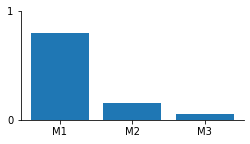

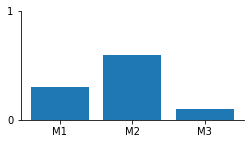

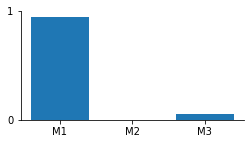

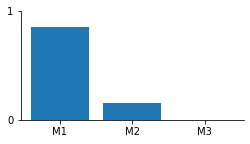

In [23]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([
    [0.80, 0.15, 0.05],
    [0.30, 0.60, 0.10],
    [0.95, 0.00, 0.05],
    [0.85, 0.15, 0.00]
])

for i in range(x.shape[0]):
    plt.figure(figsize=(4,2))
    plt.bar(np.arange(x[i].shape[0]), x[i])
    
    frame1 = plt.gca()
    #frame1.axes.get_yaxis().set_visible(False)
    
    frame1.spines['right'].set_visible(False)
    frame1.spines['top'].set_visible(False)
    
    plt.ylim([0,1])
    plt.xticks(np.arange(x[i].shape[0]), ['M1', 'M2', 'M3'])
    plt.yticks([0, 1])
    
    plt.show()

In [17]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import argparse

import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from lateral_connections import LateralModel, VggModel
from lateral_connections import VggWithLCL
from lateral_connections import MNISTCDataset
from lateral_connections.loaders import get_loaders
from lateral_connections.character_models import VGGReconstructionLCL

import wandb
import datetime

DO_WANDB = False

def get_config(random_k_change=False, random_multiplex_selection=False, use_scaling=False):
    return {
        'num_classes': 10,
        'learning_rate': 3e-5,
        'num_multiplex': 4,
        'batch_size': 10,
        'num_epochs': 10,
        'lcl_alpha': 1e-3,
        'lcl_eta': 1.0,
        'lcl_theta': 0.0,
        'lcl_iota': 0.5,
        'lcl_distance': 2,
        'lcl_k': 5,
        'mnistc_corruption': 'gaussian_noise',
        'model_path': '',
        'after_pooling': 5,

        'use_scaling': use_scaling,
        'random_multiplex_selection': random_multiplex_selection,
        'gradient_learn_k': False,
        'random_k_change': random_k_change,
        'fc_only': False
    }

def load_model(model_path, config):
    vgg = VggWithLCL(config['num_classes'], learning_rate=config['learning_rate'], dropout=0.2)
    model = VGGReconstructionLCL(vgg, learning_rate=config['learning_rate'], after_pooling=config['after_pooling'],
        num_multiplex=config['num_multiplex'], run_identifier='', lcl_distance=config['lcl_distance'],
        lcl_alpha=config['lcl_alpha'], lcl_eta=config['lcl_eta'], lcl_theta=config['lcl_theta'], lcl_iota=config['lcl_iota'],
        random_k_change=config['random_k_change'],
        random_multiplex_selection=config['random_multiplex_selection'],
        gradient_learn_k=config['gradient_learn_k'],
        fc_only=config['fc_only'],
        freeze_vgg=True)
    del vgg
    
    model.load(model_path)
    return model

def plot_lcl_kernel(model, num_plots=5, num_multiplex=4, plot_scale=2, plot_title=None):
    num_total = num_plots * num_multiplex
    num_fms = model.features.lcl.K.shape[0] // num_multiplex
    
    fig, axs = plt.subplots(num_total, num_total, figsize=(num_total*plot_scale, num_total*plot_scale))
    
    for xp in range(num_plots):
        for xm in range(num_multiplex):
            for yp in range(num_plots):
                for ym in range(num_multiplex):
                    x = xp + xm * num_fms
                    y = yp + ym * num_fms
                    axs[xp+xm*num_plots,yp+ym*num_plots].imshow(model.features.lcl.K[x, y, ...].cpu().detach().numpy())
    
    if plot_title:
        plt.suptitle(plot_title)
            
    plt.tight_layout()
    plt.show()

MODELS = {
    'default': {
        'model_path': 'models/vgg_reconstructed_lcl/2022-05-29_014117_LCL5_d2__it48750_e9.pt',
        'config': get_config()
    },
    'scaling': {
        'model_path': 'models/vgg_reconstructed_lcl/2022-05-31_093329_LCL5_d2__it48750_e9.pt',
        'config': get_config(use_scaling=True)
    },
    'random_k_change': {
        'model_path': 'models/vgg_reconstructed_lcl/2022-05-29_014022_LCL5_d2__it48750_e9.pt',
        'config': get_config(random_k_change=True)
    },
    'random_multiplex': {
        'model_path': 'models/vgg_reconstructed_lcl/2022-05-29_014228_LCL5_d2__it48750_e9.pt',
        'config': get_config(random_multiplex_selection=True)
    }
}

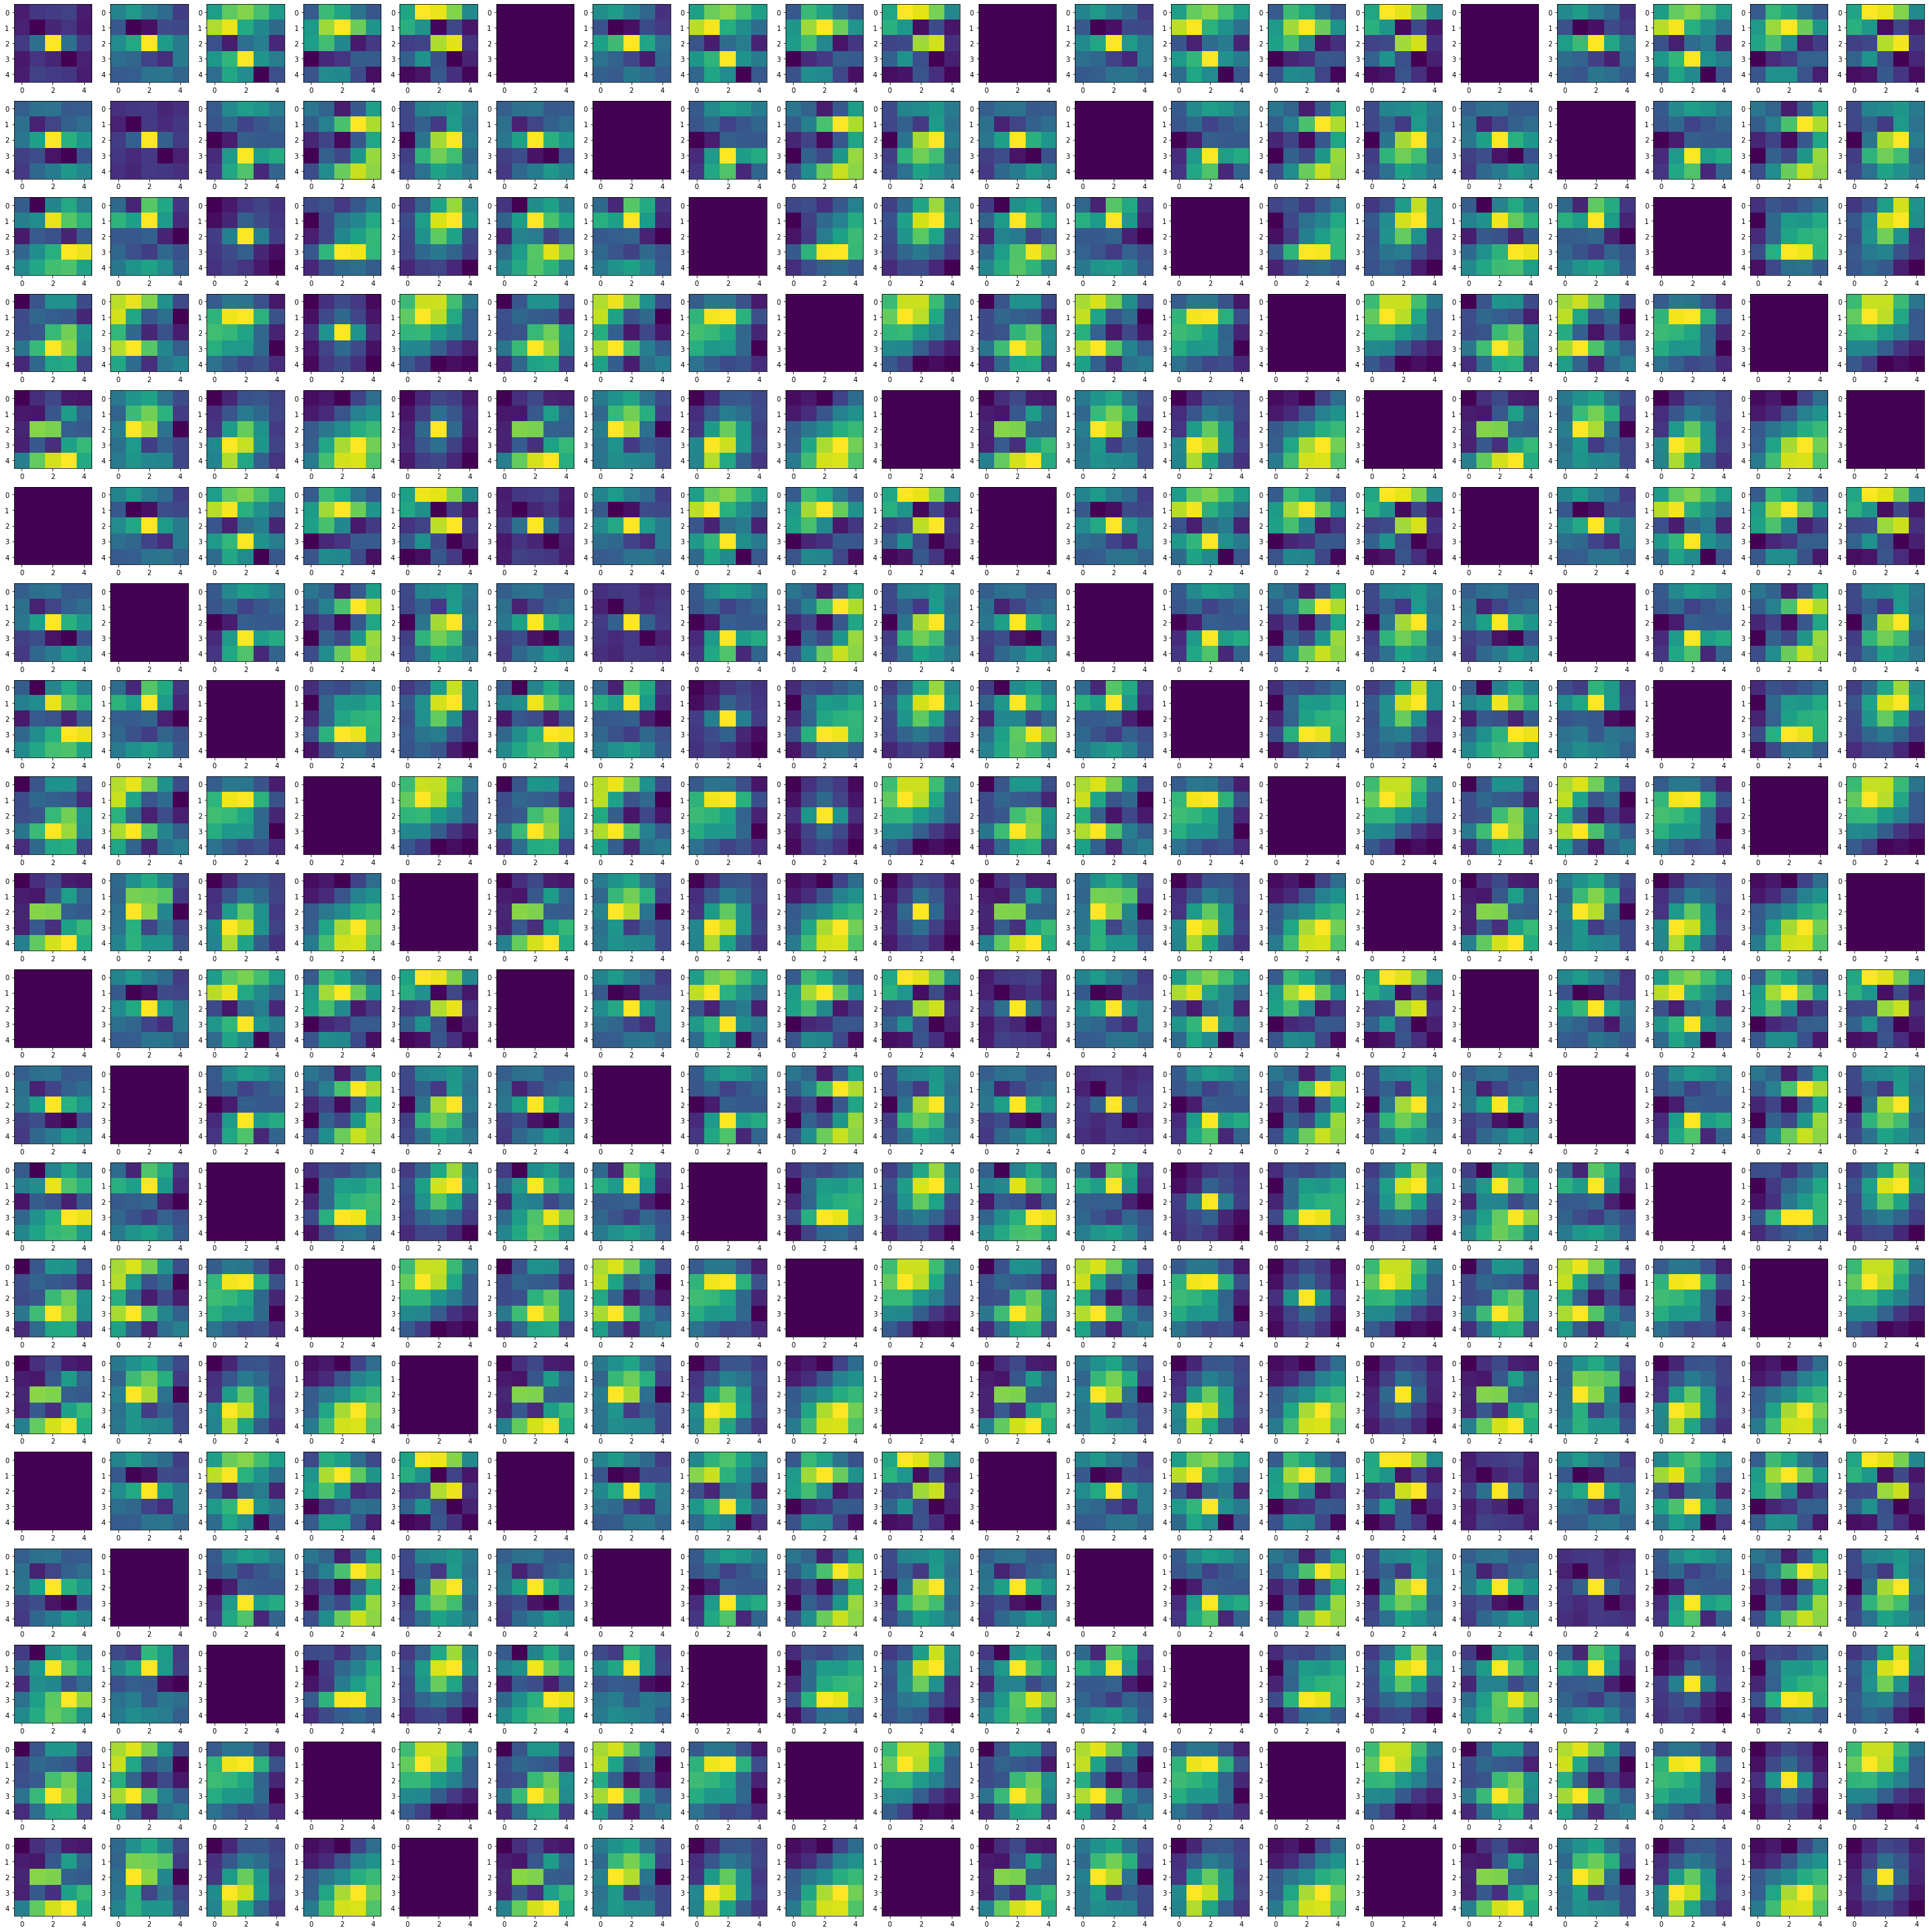

In [6]:
model_path = 'models/vgg_reconstructed_lcl/2022-06-01_215706_LCLv35_d2__it30000_e6.pt'

vgg = VggWithLCL(10, learning_rate=0, dropout=0.2)
model = VGGReconstructionLCL(vgg, learning_rate=3e-5, after_pooling=5,
    num_multiplex=4, run_identifier='', lcl_distance=2,
    lcl_alpha=1e-3, lcl_eta=1, lcl_theta=0, lcl_iota=0.5,
    random_k_change=False,
    random_multiplex_selection=False,
    gradient_learn_k=False,
    fc_only=False,
    freeze_vgg=True,
    use_new_lcl=True)
del vgg

model.load(model_path)
plot_lcl_kernel(model)

Modell: 'default'


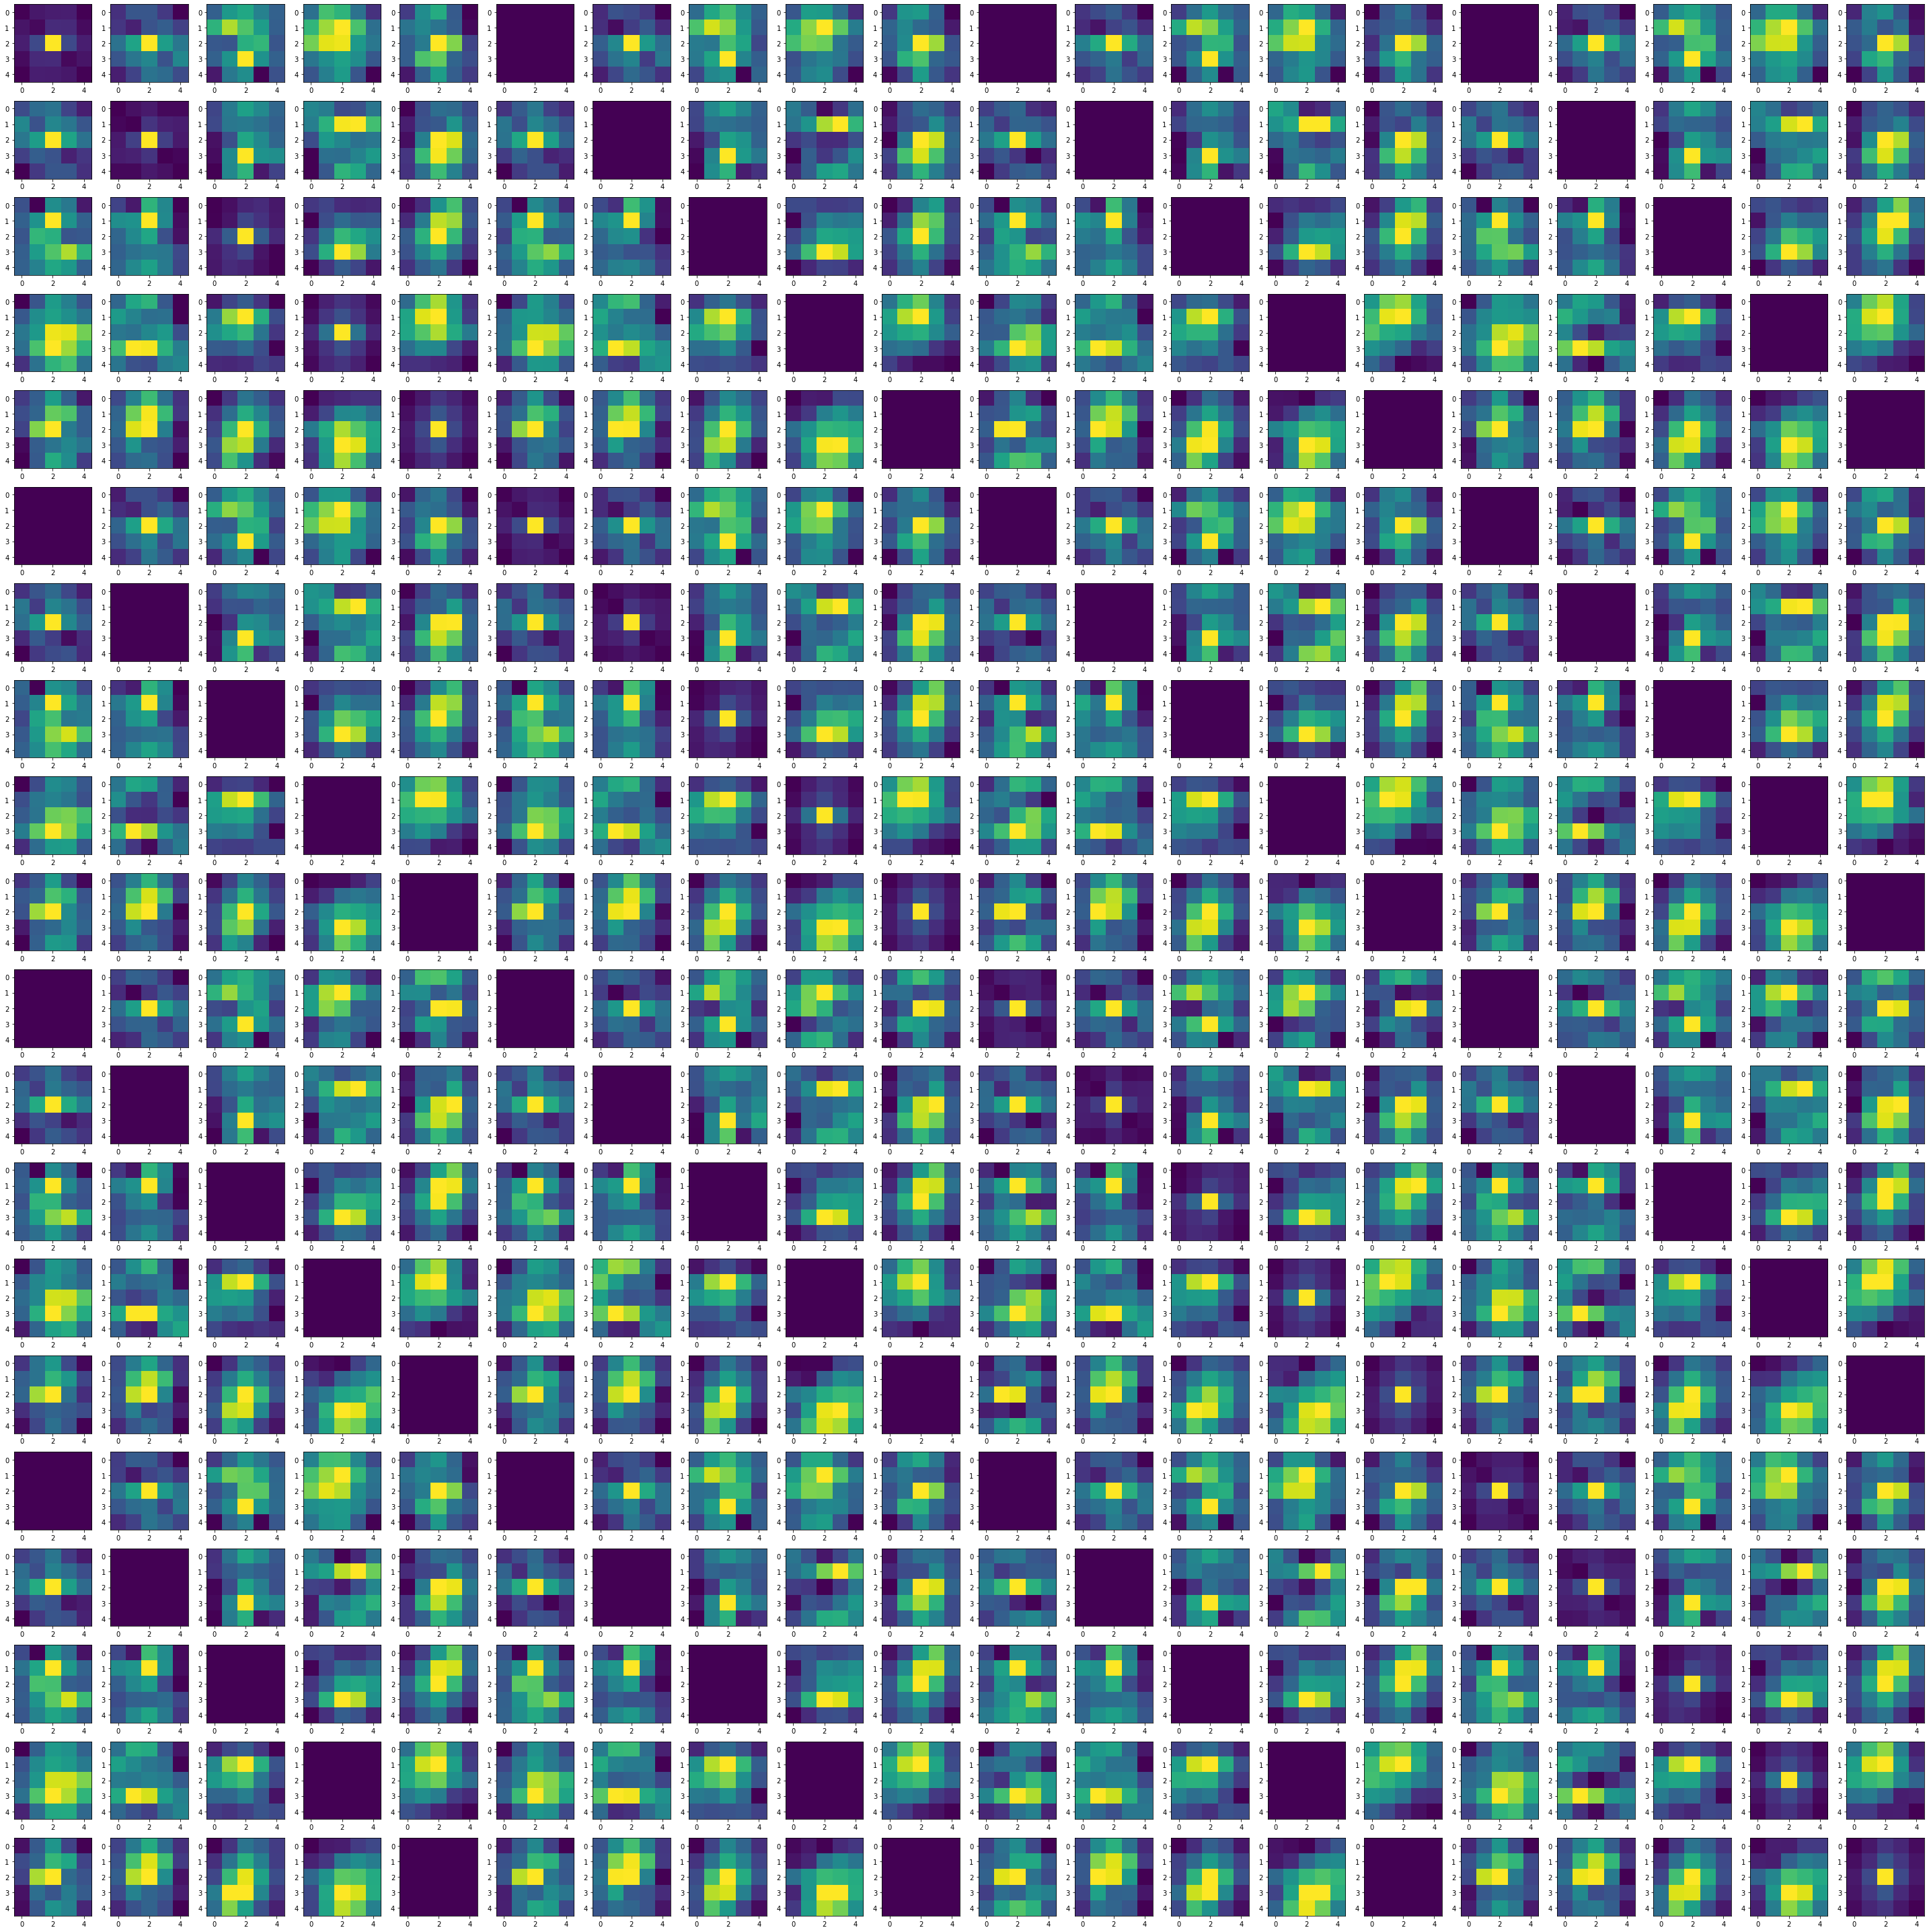

Modell: 'scaling'


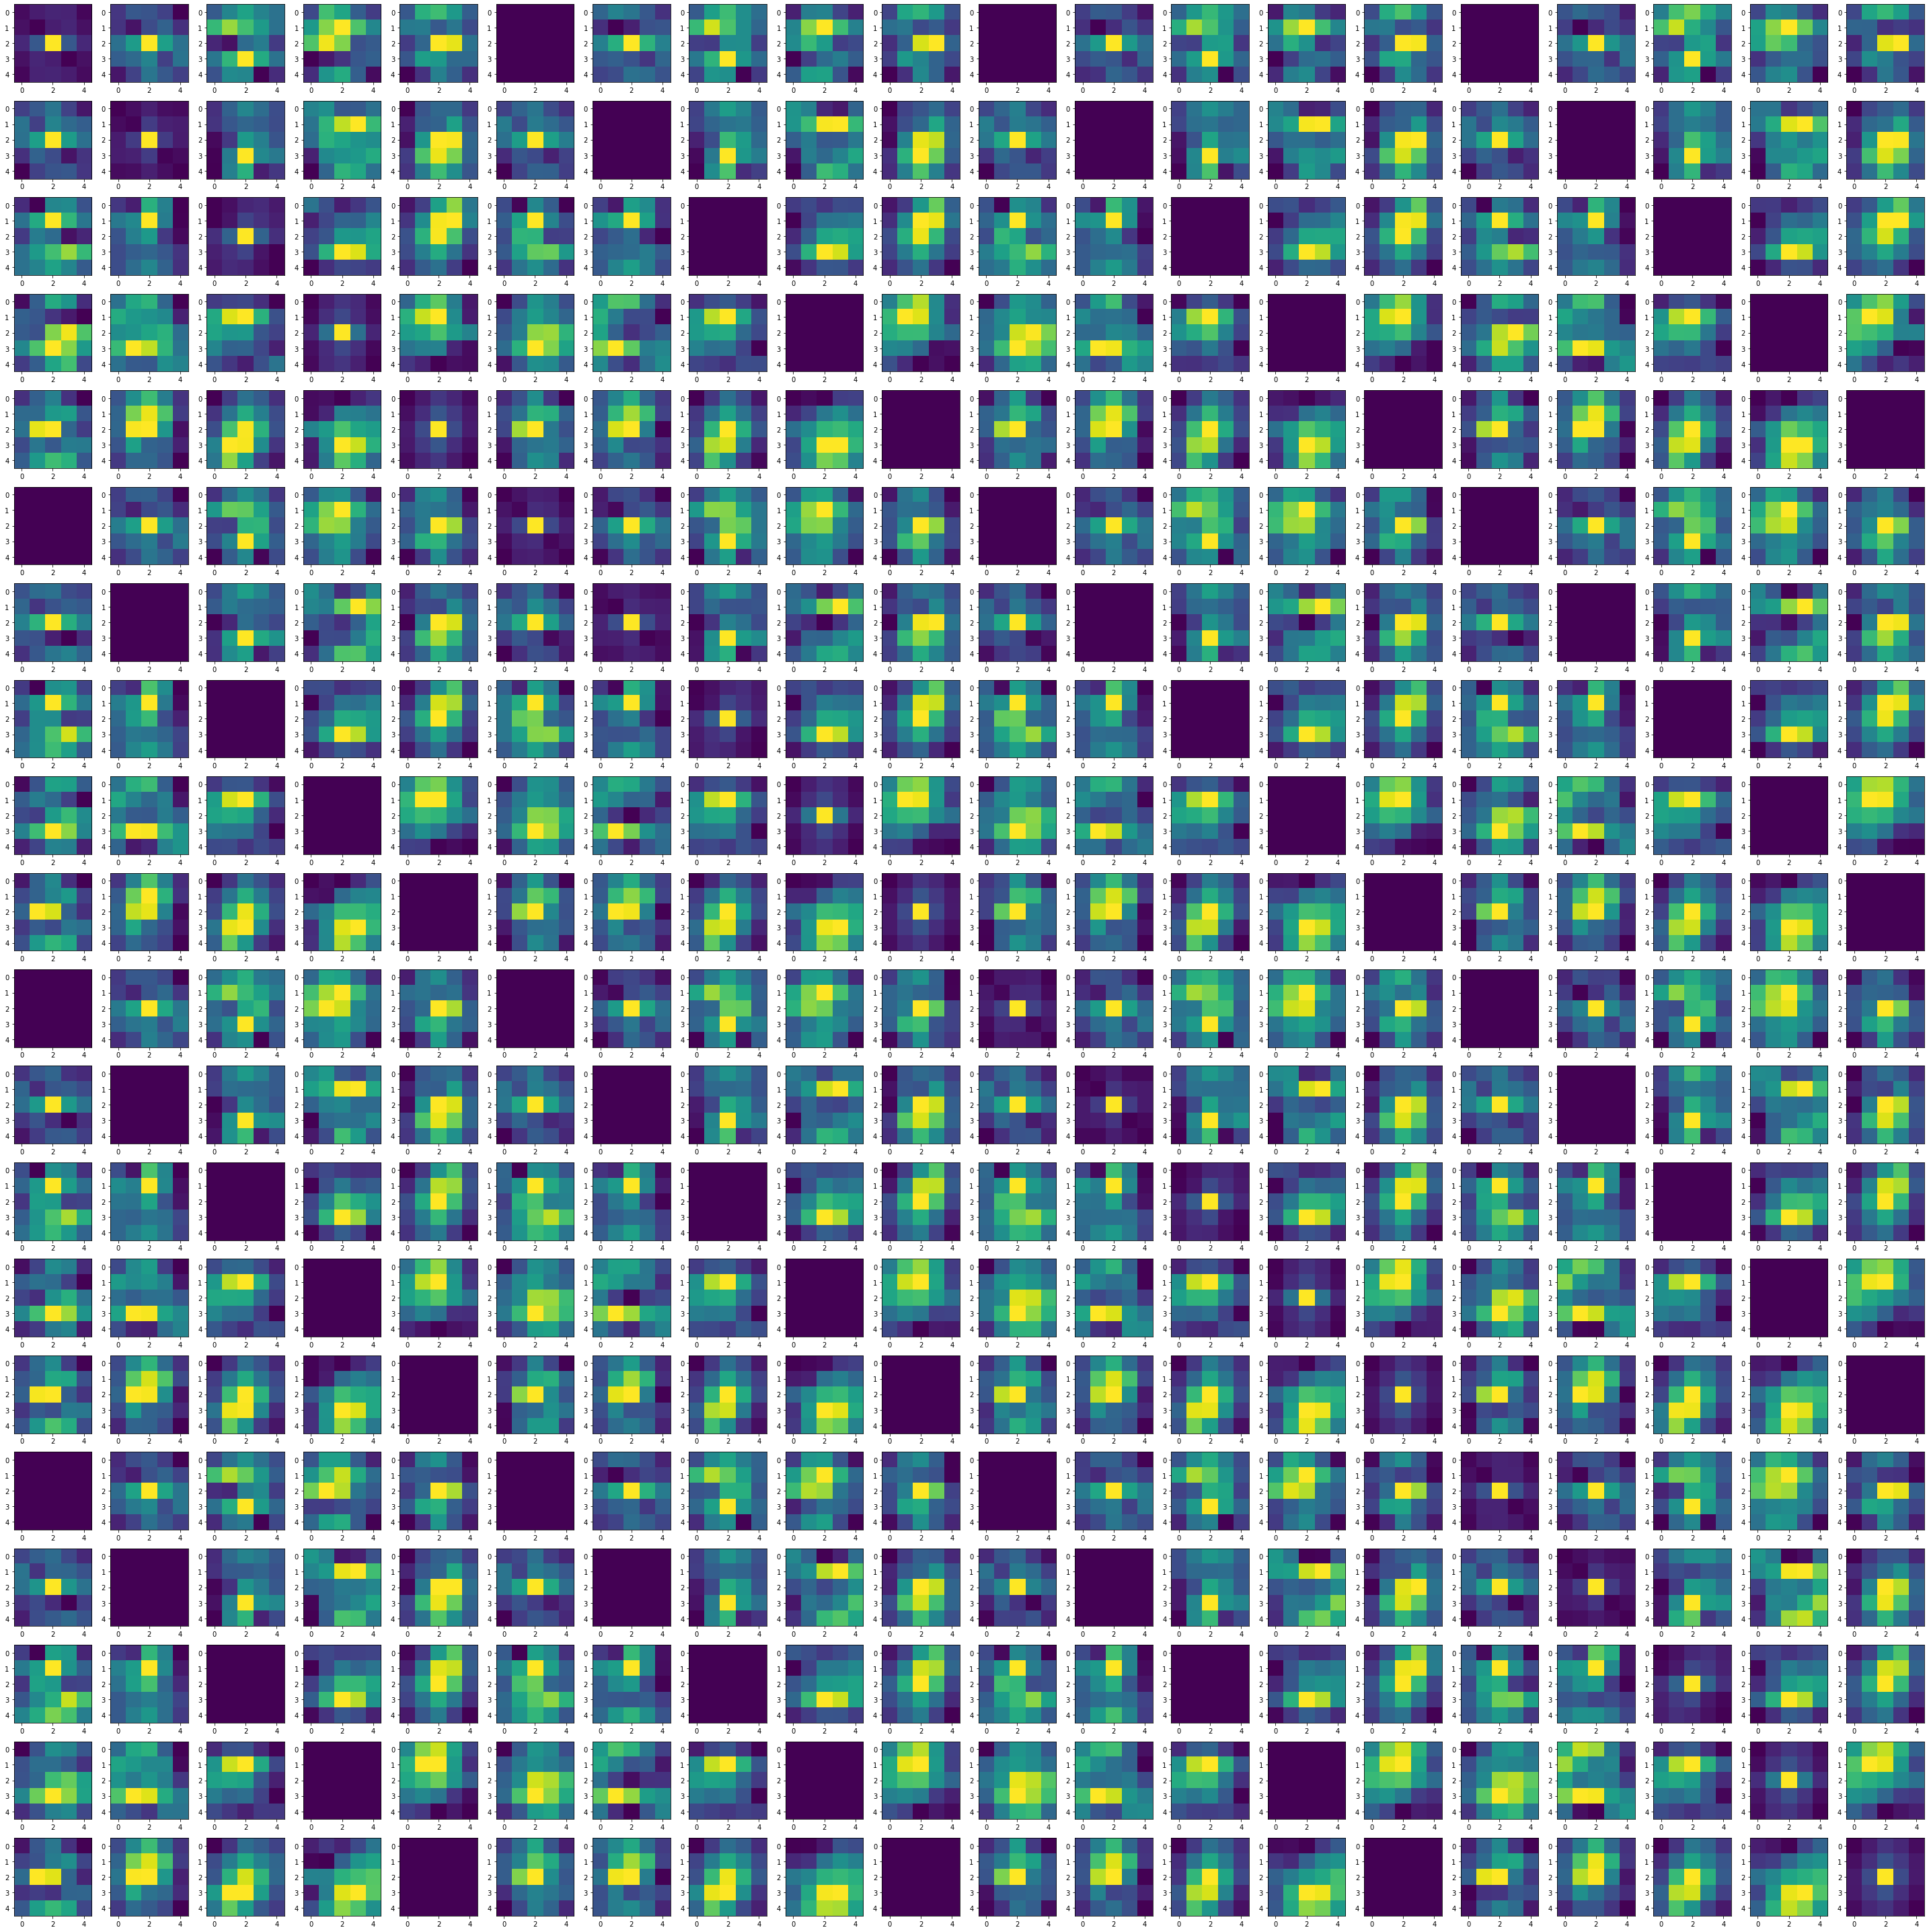

Modell: 'random_k_change'


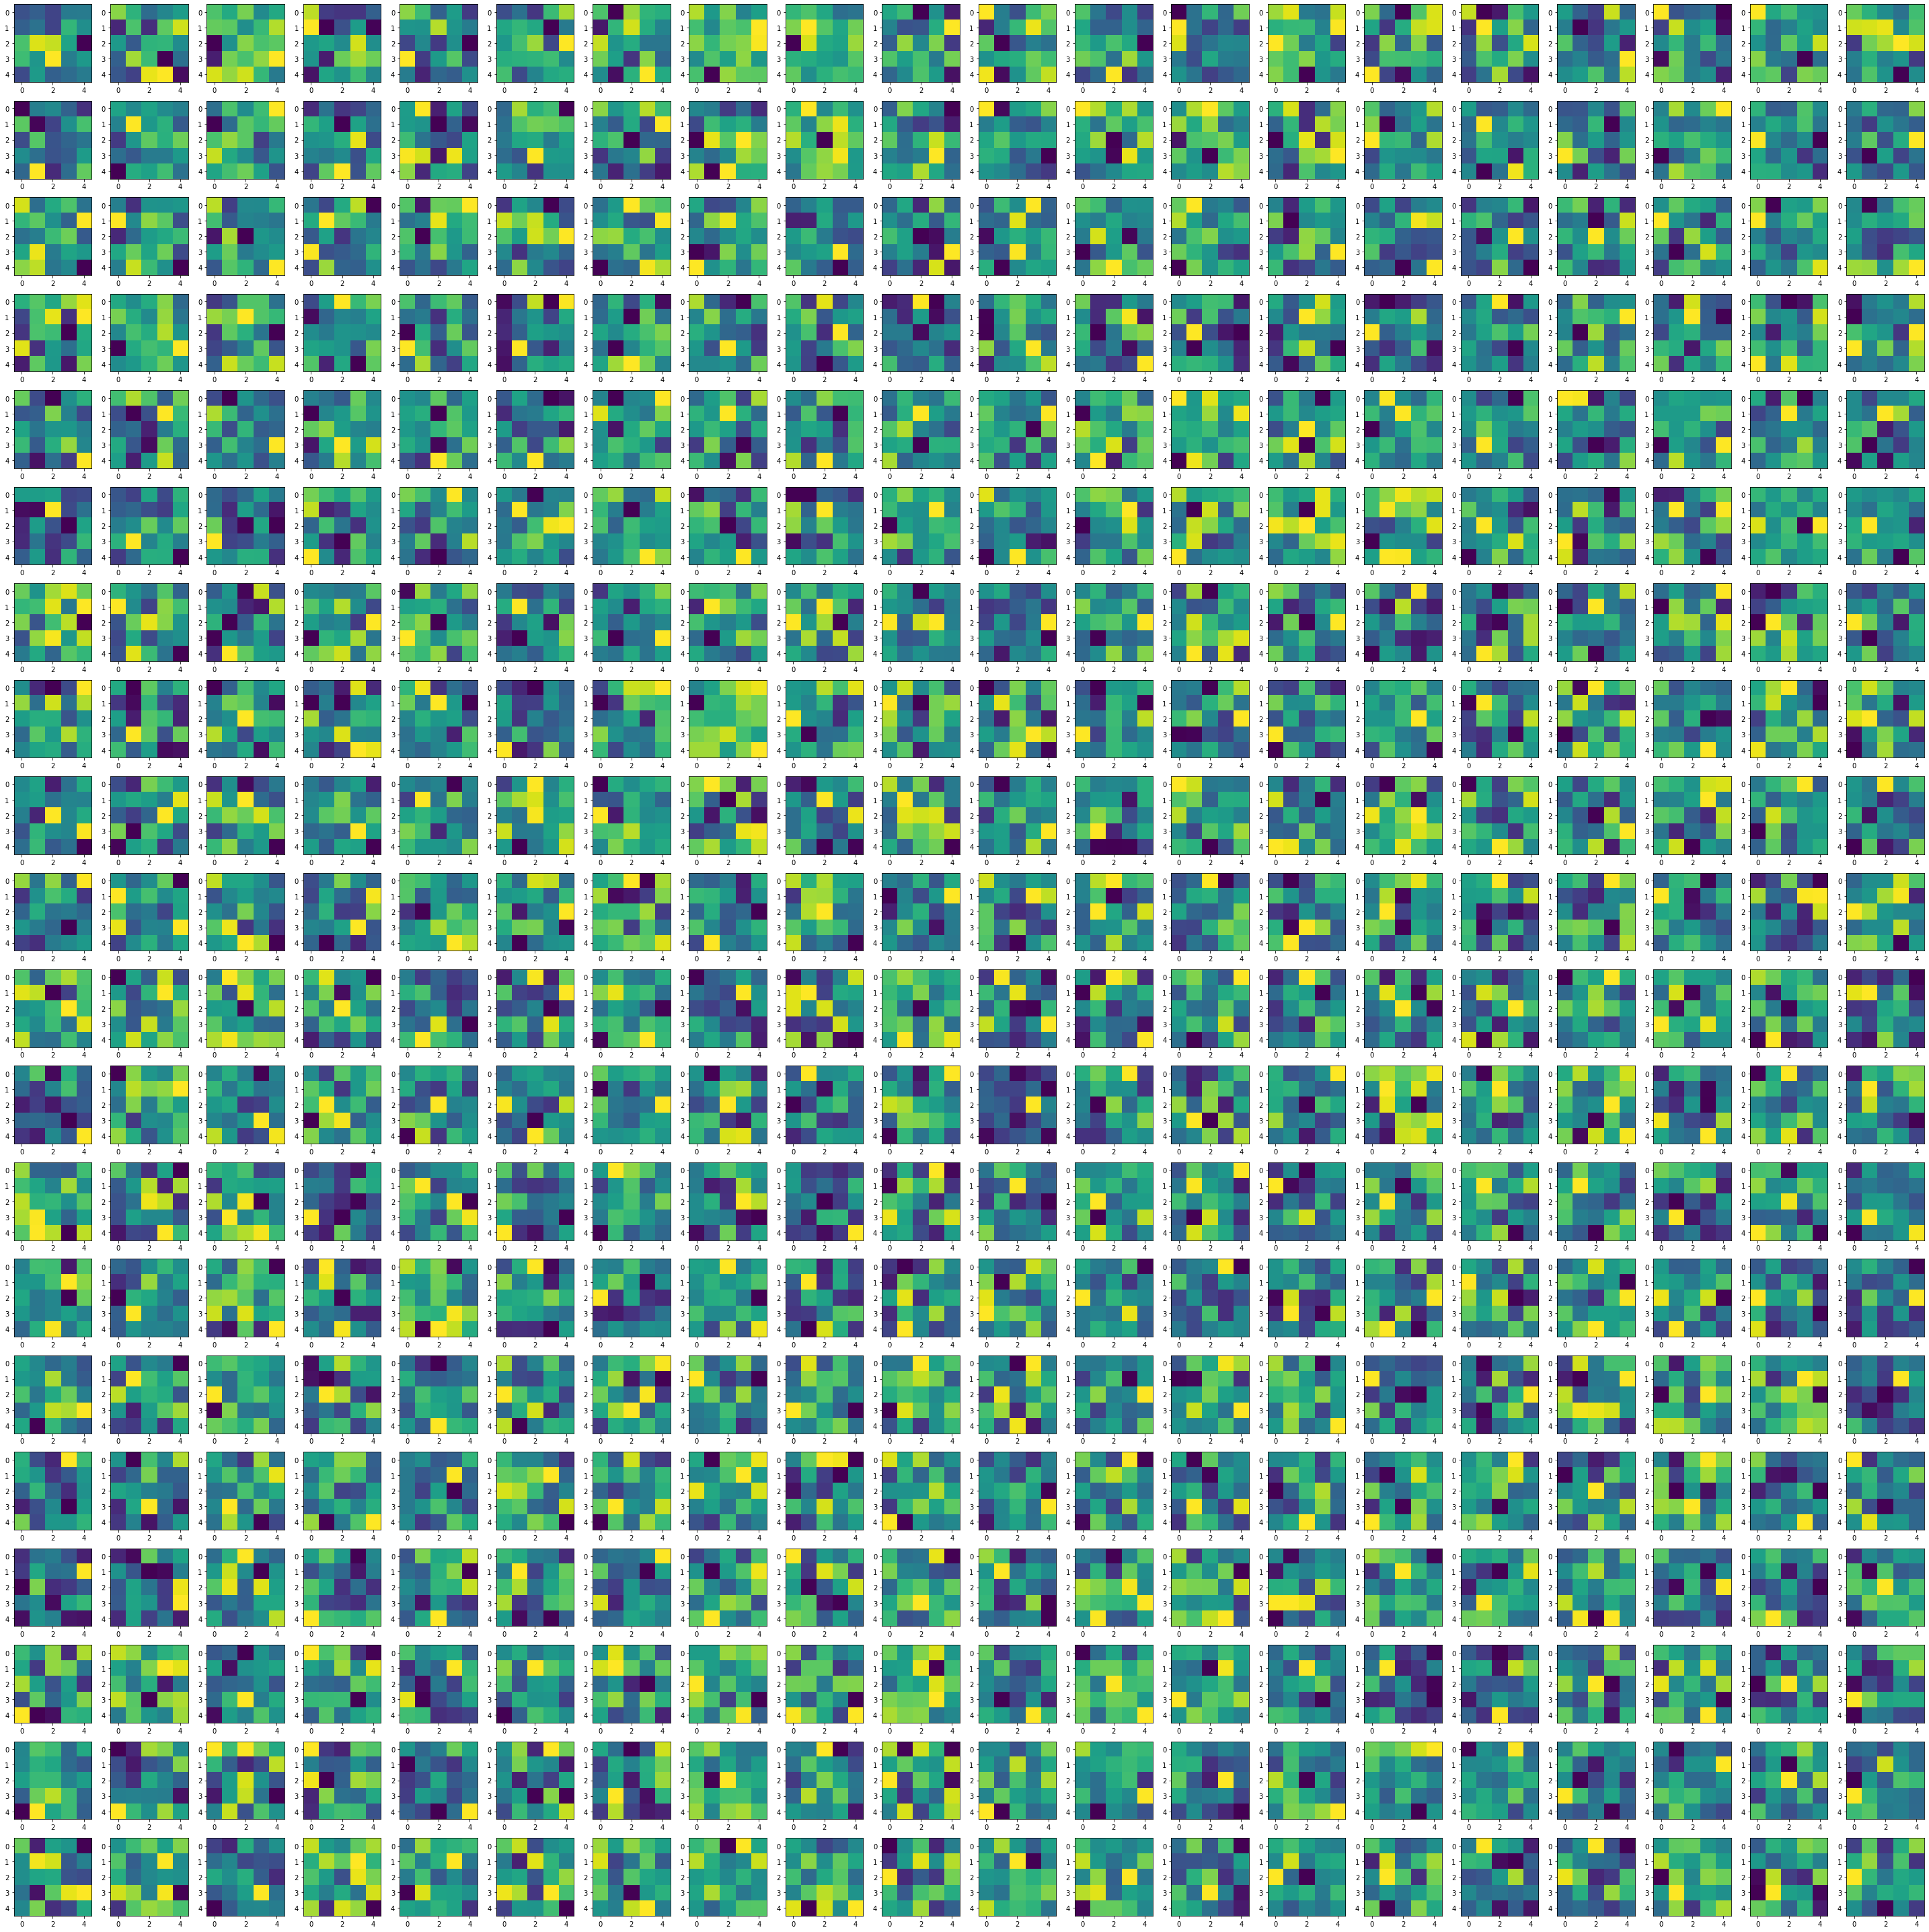

Modell: 'random_multiplex'


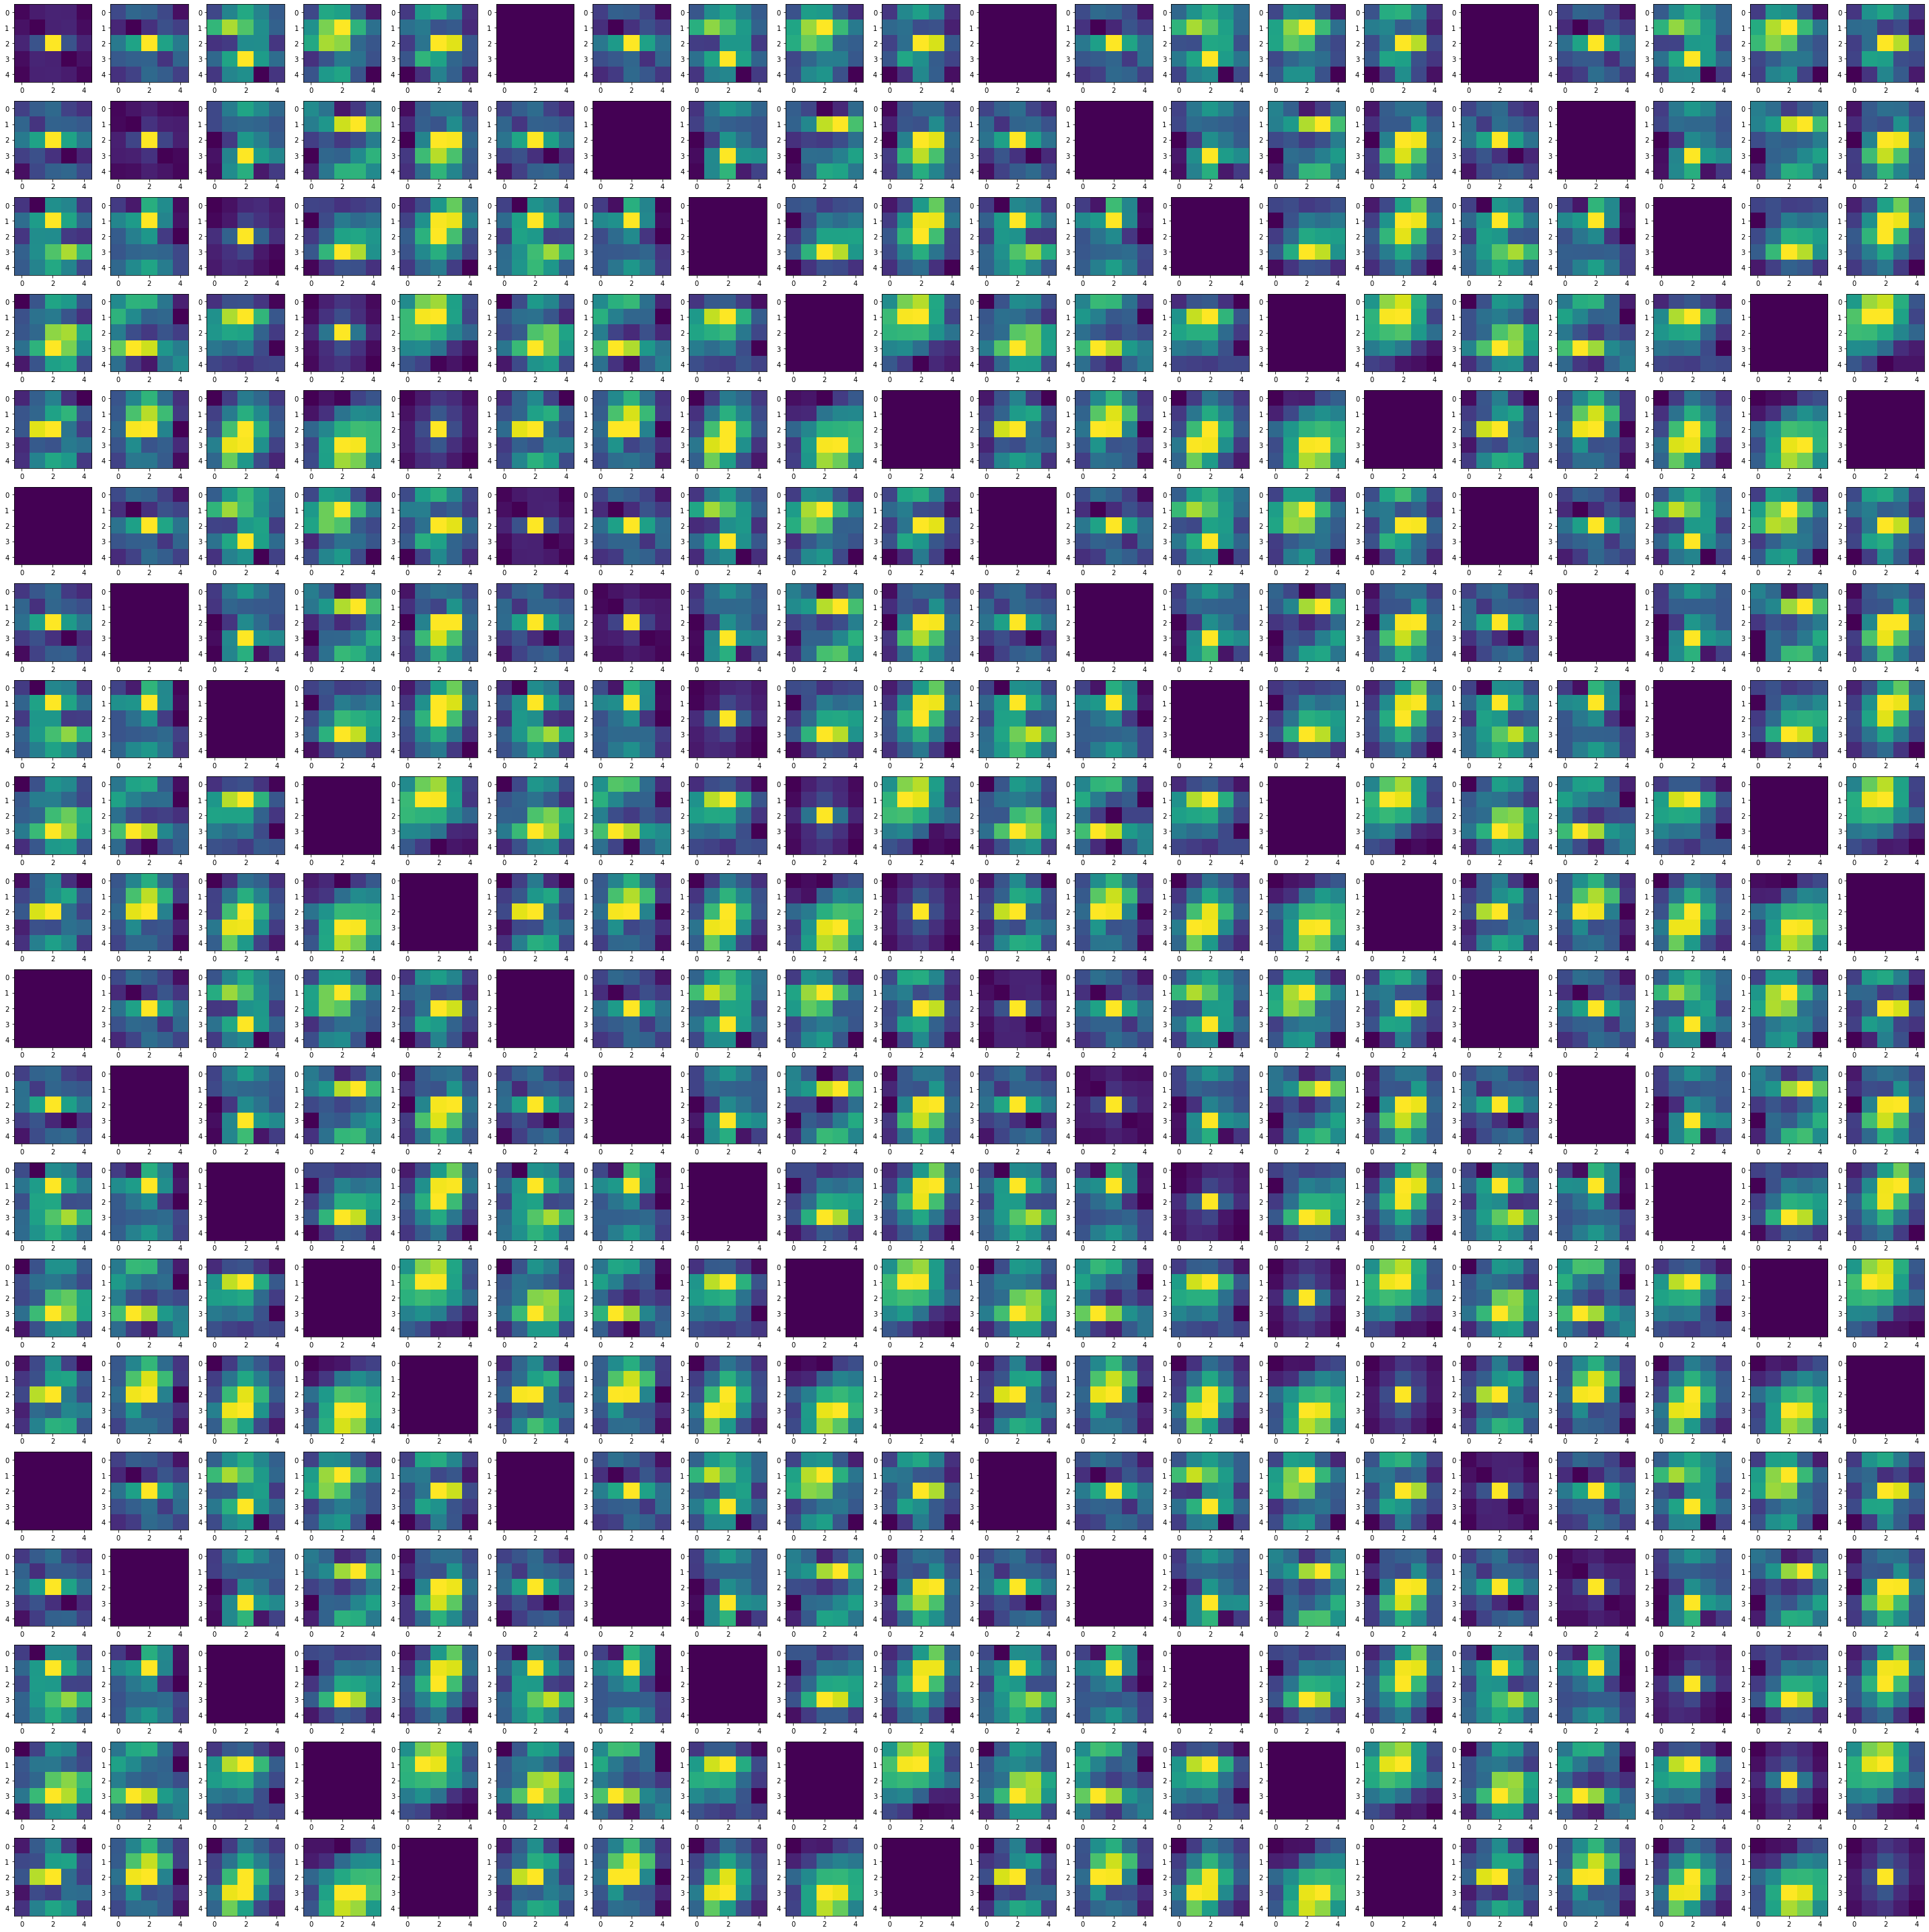

In [37]:
for model_key in MODELS.keys():
    model_data = MODELS[model_key]
    model = load_model(model_data['model_path'], model_data['config'])
    print(f"Modell: '{model_key}'")
    plot_lcl_kernel(model)

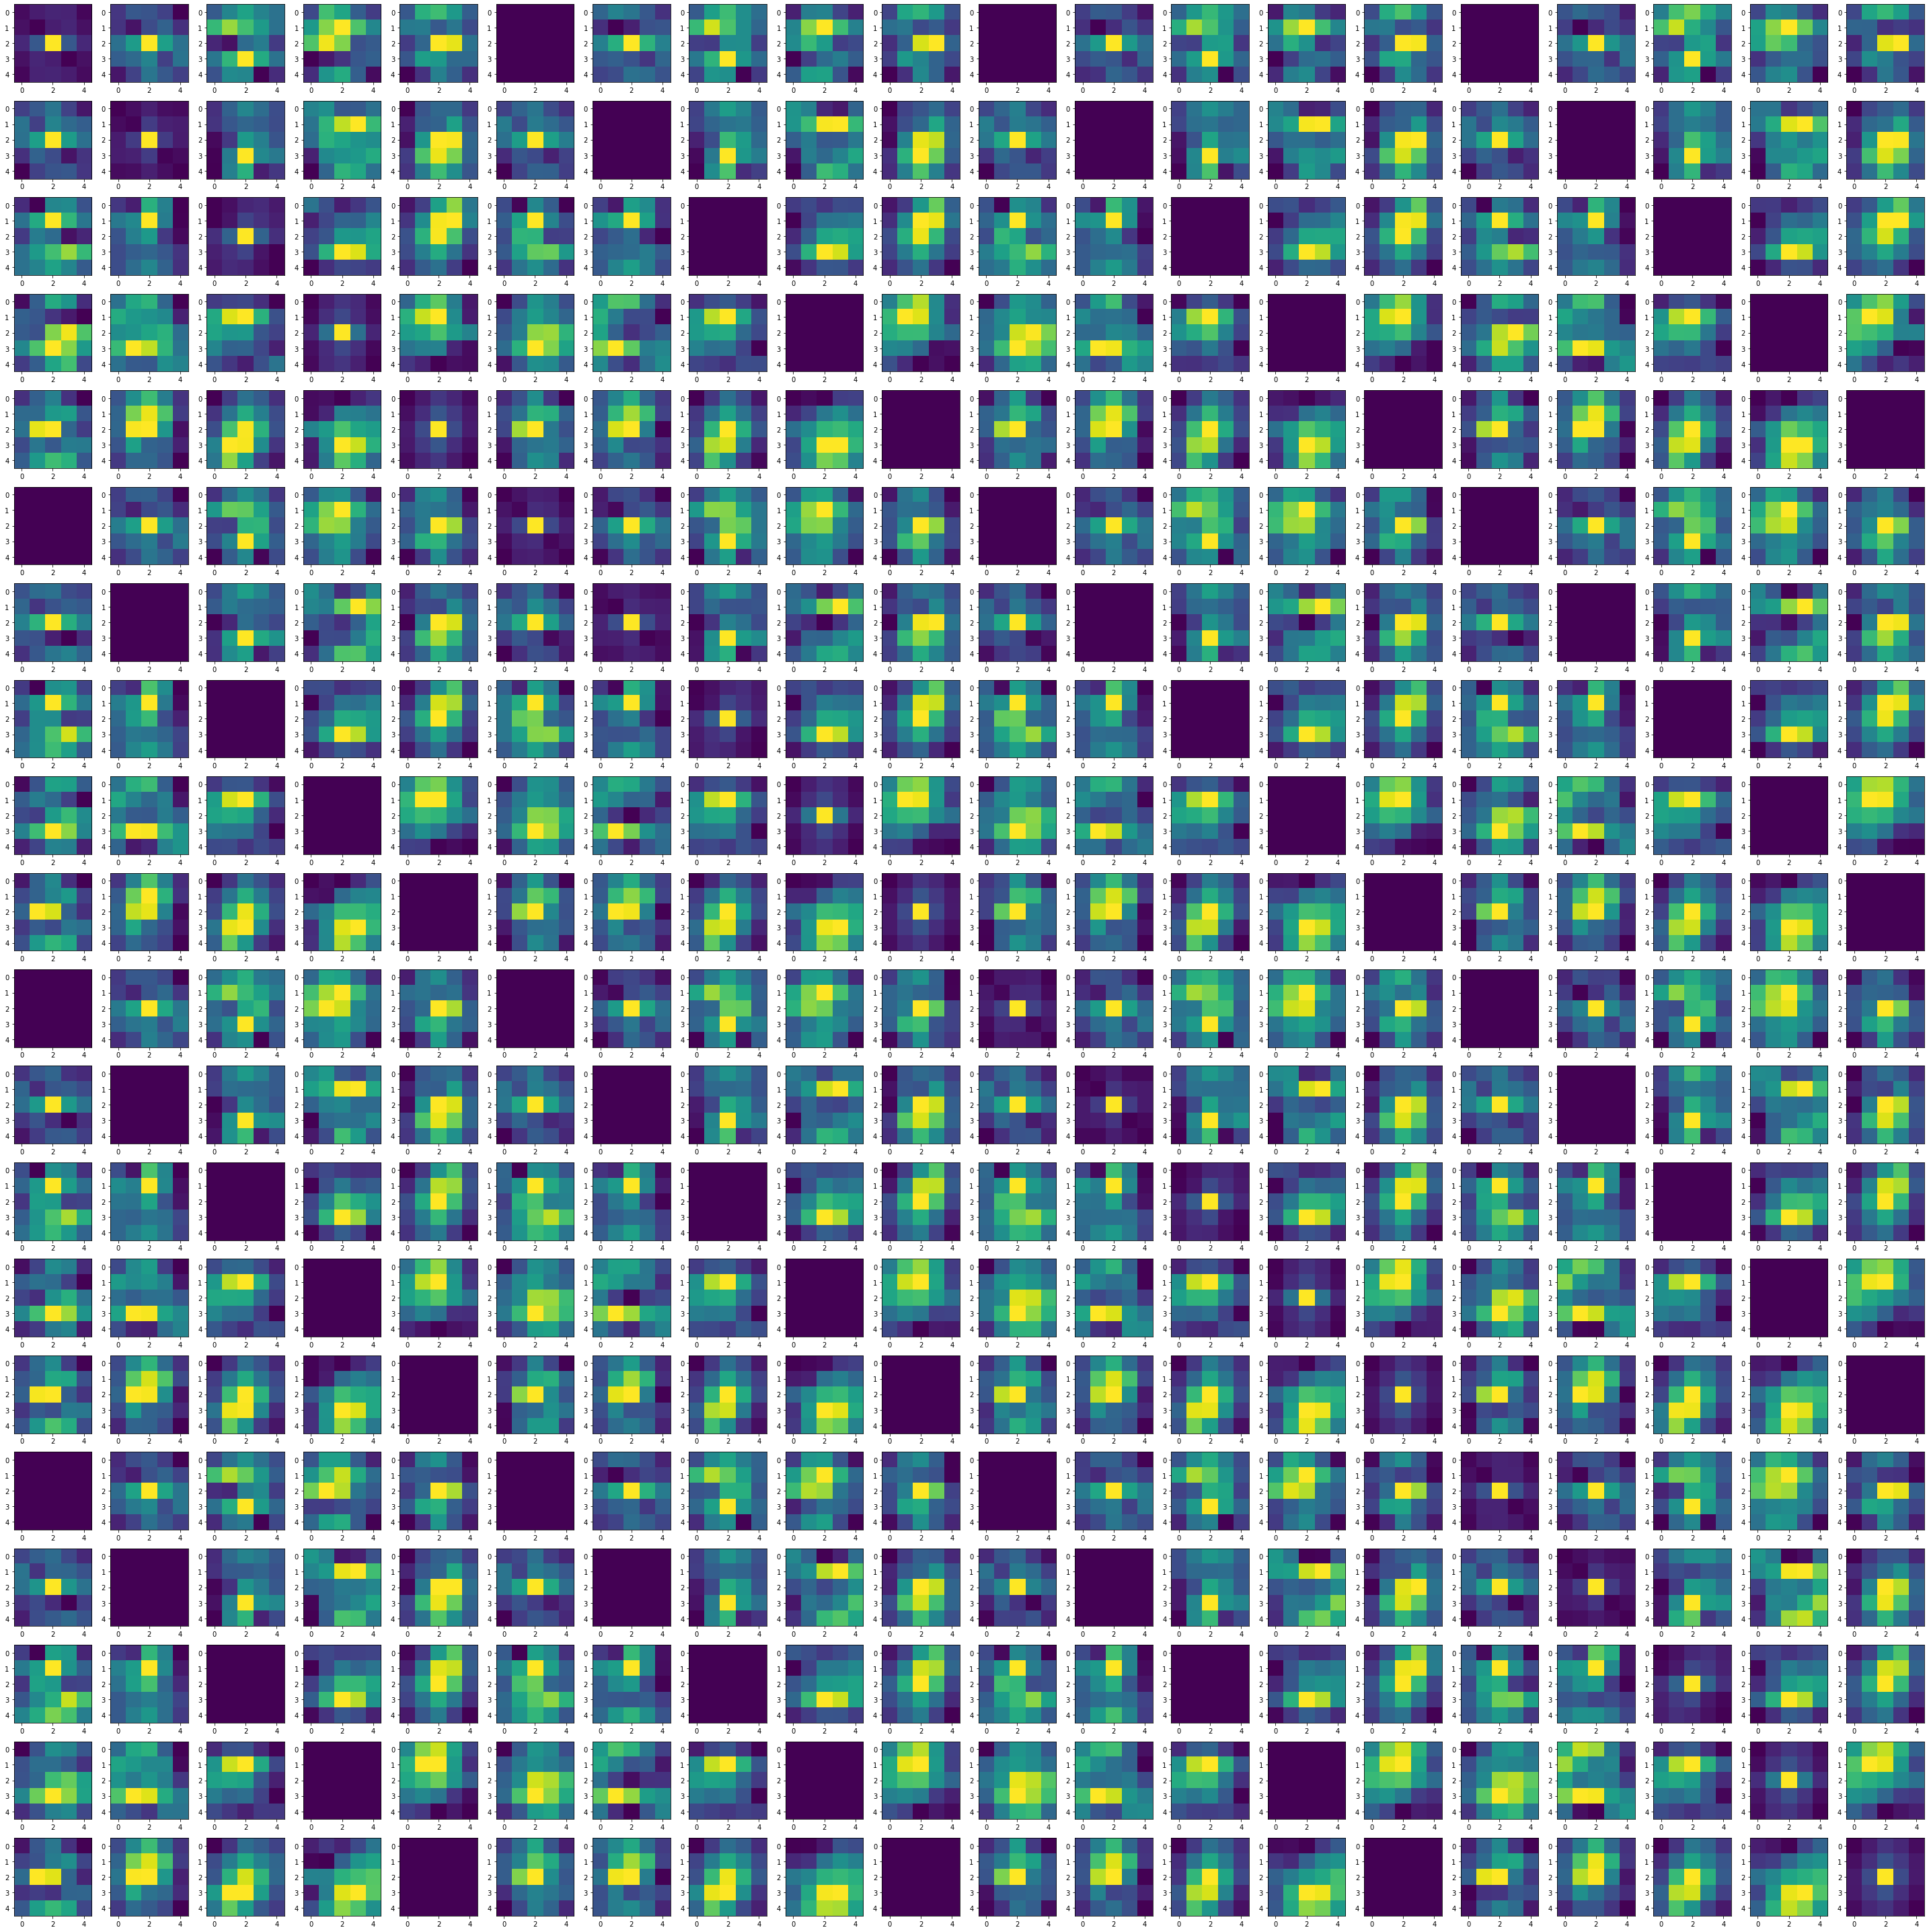

In [36]:
model_key = 'scaling'
model_data = MODELS[model_key]
model = load_model(model_data['model_path'], model_data['config'])
plot_lcl_kernel(model)

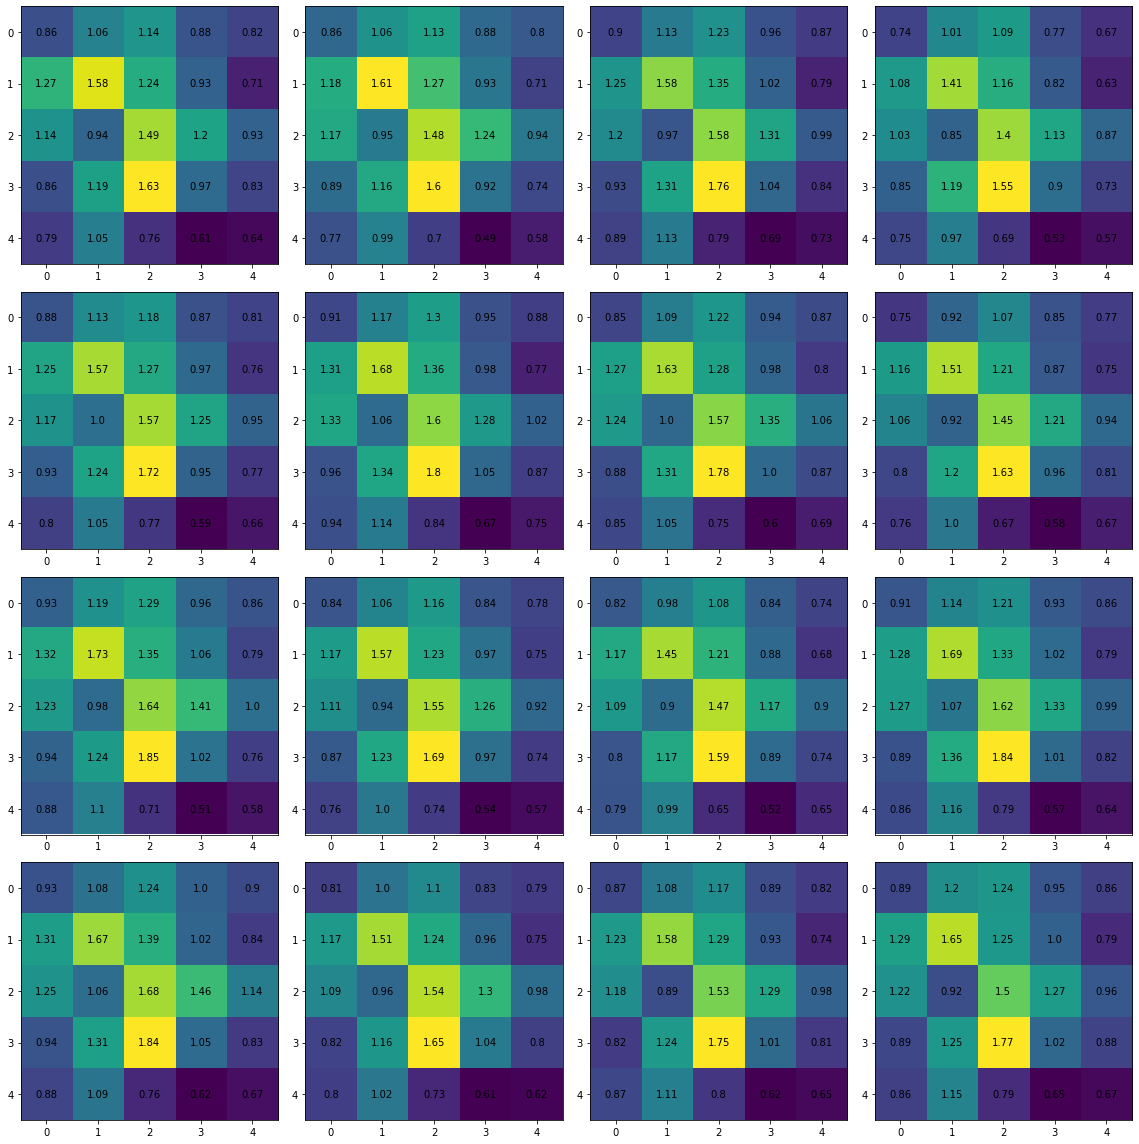

In [48]:
model.features.lcl.K

source = np.random.randint(512)
target = np.random.randint(512)
source, target

fig, axs = plt.subplots(4,4,figsize=(16,16))

for i in range(4):
    for j in range(4):
        kernel = model.features.lcl.K[source + i*512, target+j*512].cpu()
        axs[i,j].imshow(kernel) 
        
        for x in range(kernel.shape[0]):
            for y in range(kernel.shape[1]):
                axs[i,j].text(y, x, round(kernel[x,y].item(),2), ha='center', va='center')
        
plt.tight_layout()
plt.show()
